In [15]:
import pandas as pd
import numpy as np
import catboost as cb
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [16]:
testing = pd.read_csv('poker-hand-testing.csv',names=['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5','hand'])
training = pd.read_csv('poker-hand-training-true.csv',names=['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5','hand'])

In [17]:
testing.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,hand
0,1,1,1,13,2,4,2,3,1,12,0
1,3,12,3,2,3,11,4,5,2,5,1
2,1,9,4,6,1,4,3,2,3,9,1
3,1,4,3,13,2,13,2,1,3,6,1
4,3,10,2,7,1,2,2,11,4,9,0


In [18]:
training.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,hand
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


In [19]:
print(training.shape)
print(testing.shape)

(25010, 11)
(1000000, 11)


# baseline

In [20]:
X = training.drop(['hand'],axis=1)
print(X.shape)
y = training.hand
Xte = testing.drop(['hand'],axis=1)
print(Xte.shape)
yte = testing.hand

(25010, 10)
(1000000, 10)


In [22]:
model = cb.CatBoostClassifier(iterations=1000,learning_rate=0.1, loss_function='MultiClassOneVsAll',
                              verbose=False)
model.fit(X, y)
preds_class = model.predict(Xte, prediction_type='Class');
cat_predLLt = model.predict(Xte, prediction_type='Probability')
print("Test accuracy: {}".format(accuracy_score(yte,preds_class)))
print("Test logloss: {}".format(log_loss(yte,cat_predLLt)))
# (cat_predA, cat_predLL, cat_predAt, cat_predLLt) = CVandTest(X,y,Xte,yte)

Test accuracy: 0.788548
Test logloss: 0.5706435367637872


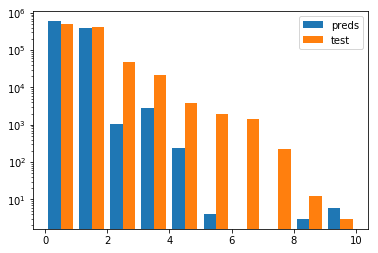

In [23]:
plt.hist((np.reshape(preds_class,(yte.shape[0],)),yte),bins=[0,1,2,3,4,5,6,7,8,9,10],log=True)
plt.legend(labels=('preds','test'))
plt.show()

# Feature Generation

In [24]:
#Combine training and testing to create features for both together at the same time
all_data = pd.concat([training, testing]).reset_index(drop=True)

In [25]:
#Number of same suites and ranks sparse matrix creation using bincount2D_vectorized
#https://stackoverflow.com/questions/46256279/bin-elements-per-row-vectorized-2d-bincount-for-numpy
def bincount2D_vectorized(a):    
    N = a.max()+1
    a_offs = a + np.arange(a.shape[0])[:,None]*N
    return np.bincount(a_offs.ravel(), minlength=a.shape[0]*N).reshape(-1,N)

S = all_data.iloc[:,[0,2,4,6,8]].astype(int)
S = pd.DataFrame(bincount2D_vectorized(S.values),columns=['suit0','suit1','suit2','suit3','suit4'])
all_data = pd.merge(all_data, S, how='left', left_index=True, right_index=True).drop(['suit0'],axis=1)
#bincount starts counting from 0, but our suits start at 1.  Dropping suit0.

R = all_data.iloc[:,np.arange(1,10,2)].astype(int)
cols = ['rank{}'.format(x) for x in range(0,14,1)]
R = pd.DataFrame(bincount2D_vectorized(R.values),columns=cols)
all_data = pd.merge(all_data, R, how='left', left_index=True, right_index=True).drop(['rank0'],axis=1)
#bincount starts counting from 0, but our ranks start at 1.  Dropping rank0.

all_data.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,...,rank4,rank5,rank6,rank7,rank8,rank9,rank10,rank11,rank12,rank13
0,1,10,1,11,1,13,1,12,1,1,...,0,0,0,0,0,0,1,1,1,1
1,2,11,2,13,2,10,2,12,2,1,...,0,0,0,0,0,0,1,1,1,1
2,3,12,3,11,3,13,3,10,3,1,...,0,0,0,0,0,0,1,1,1,1
3,4,10,4,11,4,1,4,13,4,12,...,0,0,0,0,0,0,1,1,1,1
4,4,1,4,13,4,12,4,11,4,10,...,0,0,0,0,0,0,1,1,1,1


In [26]:
#Splitting back to train/test
X = all_data.iloc[:25010,:].drop(['hand'],axis=1)
print(X.shape)
Xte = all_data.iloc[25010:,:].drop(['hand'],axis=1)
print(Xte.shape)
# (cat_predA, cat_predLL, cat_predAt, cat_predLLt) = CVandTest(X,y,Xte,yte)
model = cb.CatBoostClassifier(iterations=1000,learning_rate=0.1, loss_function='MultiClassOneVsAll',
                              verbose=False)
model.fit(X, y)
preds_class = model.predict(Xte, prediction_type='Class');
cat_predLLt = model.predict(Xte, prediction_type='Probability')
print("Test accuracy: {}".format(accuracy_score(yte,preds_class)))
print("Test logloss: {}".format(log_loss(yte,cat_predLLt)))

(25010, 27)
(1000000, 27)
Test accuracy: 0.994785
Test logloss: 0.03474002536319994


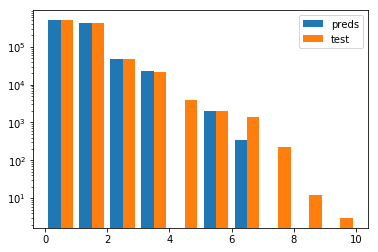

In [27]:
#Logarithmic Histogram
plt.hist((np.reshape(preds_class,(yte.shape[0],)),yte),bins=[0,1,2,3,4,5,6,7,8,9,10],log=True)
plt.legend(labels=('preds','test'))
plt.show()

# more feature

In [28]:
#Number of ranks with x's is another bincount problem
R = all_data.loc[:,['rank{}'.format(n) for n in range(1,14,1)]].astype(int)
R = pd.DataFrame(bincount2D_vectorized(R.values),columns=['rankCount{}'.format(n) for n in range(0,5,1)])
all_data = pd.merge(all_data, R, how='left', left_index=True, right_index=True).drop(['rankCount0'],axis=1)

all_data.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,...,rank8,rank9,rank10,rank11,rank12,rank13,rankCount1,rankCount2,rankCount3,rankCount4
0,1,10,1,11,1,13,1,12,1,1,...,0,0,1,1,1,1,5,0,0,0
1,2,11,2,13,2,10,2,12,2,1,...,0,0,1,1,1,1,5,0,0,0
2,3,12,3,11,3,13,3,10,3,1,...,0,0,1,1,1,1,5,0,0,0
3,4,10,4,11,4,1,4,13,4,12,...,0,0,1,1,1,1,5,0,0,0
4,4,1,4,13,4,12,4,11,4,10,...,0,0,1,1,1,1,5,0,0,0


In [29]:
#Differences between consecutive ranks: rank2 - rank1, rank3 - rank2, ..., rank13 - rank12. And rank1 - rank13
all_data['diff1_13'] = all_data['rank1'] - all_data['rank13']
for i in range(2,14,1):
    all_data['diff{}_{}'.format(i,i-1)] = all_data['rank{}'.format(i)] - all_data['rank{}'.format(i-1)]

all_data.tail()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,...,diff4_3,diff5_4,diff6_5,diff7_6,diff8_7,diff9_8,diff10_9,diff11_10,diff12_11,diff13_12
1025005,3,1,1,12,2,9,4,9,2,6,...,0,0,1,-1,0,2,-2,0,1,-1
1025006,3,3,4,5,2,7,1,4,4,3,...,-1,0,-1,1,-1,0,0,0,0,0
1025007,1,11,4,7,3,9,1,13,2,7,...,0,0,0,2,-2,1,-1,1,-1,1
1025008,3,11,1,8,1,1,3,13,2,8,...,0,0,0,0,2,-2,0,1,-1,1
1025009,2,5,2,9,4,9,2,3,3,3,...,-2,1,-1,0,0,2,-2,0,0,0


In [30]:
#Splitting back to train/test
X = all_data.iloc[:25010,:].drop(['hand'],axis=1)
print(X.shape)
Xte = all_data.iloc[25010:,:].drop(['hand'],axis=1)
print(Xte.shape)
model = cb.CatBoostClassifier(iterations=1000,learning_rate=0.1, loss_function='MultiClassOneVsAll',
                              verbose=False)
model.fit(X, y)
preds_class = model.predict(Xte, prediction_type='Class');
cat_predLLt = model.predict(Xte, prediction_type='Probability')
print("Test accuracy: {}".format(accuracy_score(yte,preds_class)))
print("Test logloss: {}".format(log_loss(yte,cat_predLLt)))

(25010, 44)
(1000000, 44)
Test accuracy: 0.999952
Test logloss: 0.0004720179664784552


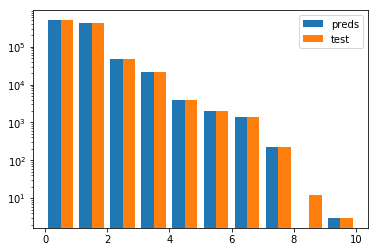

In [31]:
#Logarithmic Histogram
plt.hist((np.reshape(preds_class,(yte.shape[0],)),yte),bins=[0,1,2,3,4,5,6,7,8,9,10],log=True)
plt.legend(labels=('preds','test'))
plt.show()